## Find nearest neighbours and find cosine similarity

In [11]:
from sklearn.neighbors import NearestNeighbors
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from skimage.transform import resize
import glob, os, random

def HOG_CV(image):
    """
    Given an image, the function returns the HOG descriptor of the image using predefined parameters of the HOG 
    """
    
    ### Define hyperparameters needed for our HOG Descriptor
    winSize = (28,28)
    blockSize = (4,4) #Change block size from default to 4*4 because of smaller image
    blockStride = (2,2) #Reduced to math image size
    cellSize = (2,2) #Reduced again
    nbins = 9 #Default value of number of bins in histogram
    derivAperture = 1
    winSigma = 4. #Gaussian smoothing parameter
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    #compute(img[, winStride[, padding[, locations]]]) -> descriptors
    winStride = (8,8)
    padding = (8,8)
    locations = ((10,20),)
    hist = hog.compute(image,winStride,padding,locations)
    return hist


def find_hog(image):
    """
    A function that converts image to grayscale and performs the HOG calculations on the image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image= image.astype(np.uint8)
    hist_cv = HOG_CV(image)
    return hist_cv

## Create training and testing data

In [12]:
##Full dataset and 10 sample test set
"""
data = glob.glob(str(os.getcwd())+"\images\images\*")
test_data = np.loadtxt('TestSet.txt', delimiter = '\n')
test_data = [str(os.getcwd()) + '\\images\\images\\' + str(int(x))+ '.jpg' for x in test_data]
train_data = data
"""

### Load 1028 train set and 10 sample test set
test_data = np.loadtxt('TestSet.txt', delimiter = '\n')
train_data = np.loadtxt('NewData.txt', delimiter = '\n')
test_data = [str(os.getcwd()) + '\\images\\images\\' + str(int(x))+ '.jpg' for x in test_data]
train_data = [str(os.getcwd()) + '\\images\\images\\' + str(int(x))+ '.jpg' for x in train_data]


## Find discriptors and run KNN

In [14]:
from tqdm.notebook import tqdm #To check progress in loops
limit = len(train_data)
dic_hog = {}
bins_list = []
for file in tqdm(train_data):
    try:
        a= find_hog(cv2.imread(file))
        dic_hog[file] = [x[0] for x in a]
        bins_list.append(dic_hog[file])
    except:
        #There were cases when an image in training set was not present in our database
        print ('File not found')
        limit-=1
N_Wanted = 5 #Number of neighbours wanted
bins_list = np.array(bins_list)
bins_list = np.reshape(bins_list,(limit,len(bins_list[0])))
nbrs = NearestNeighbors(n_neighbors=N_Wanted, algorithm='ball_tree').fit(bins_list) #Fit in a ball tree structed KNN

File not found




Global Mean Cosine Similarity Descriptor is : 0.6014402
Global Mean Cosine Similarity Image for is : 0.9632911303882047


<Figure size 432x288 with 0 Axes>

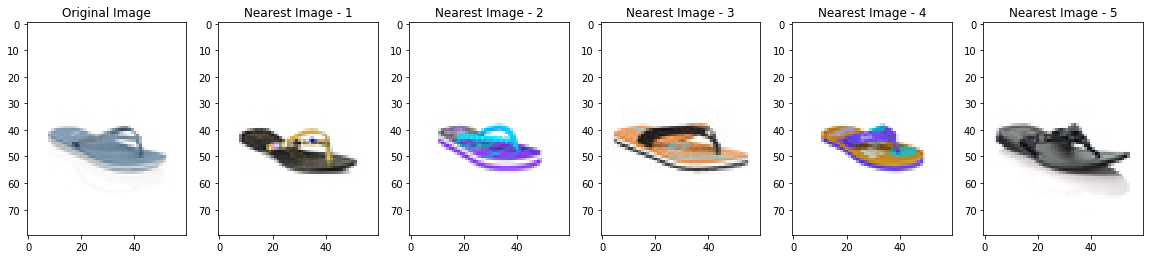

<Figure size 432x288 with 0 Axes>

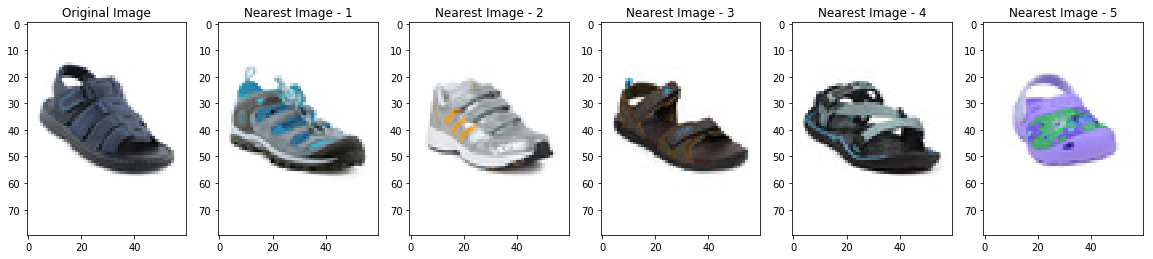

<Figure size 432x288 with 0 Axes>

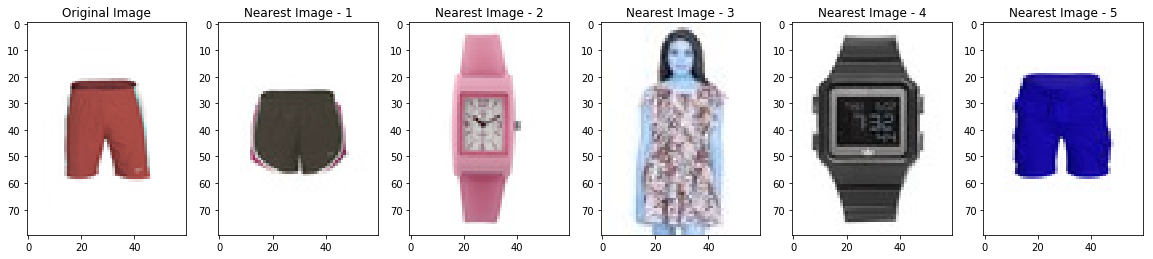

<Figure size 432x288 with 0 Axes>

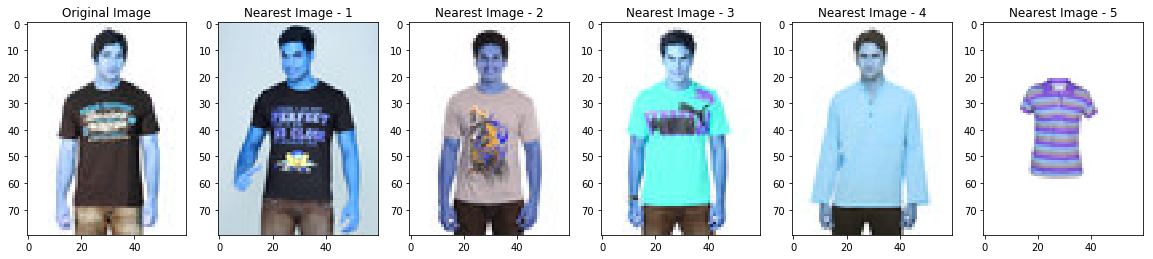

<Figure size 432x288 with 0 Axes>

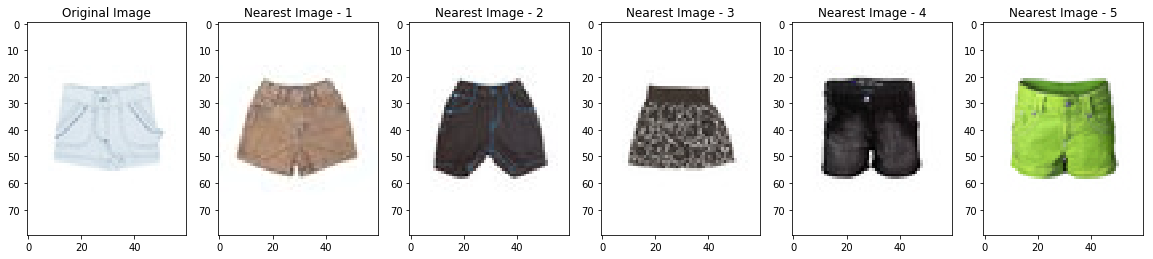

<Figure size 432x288 with 0 Axes>

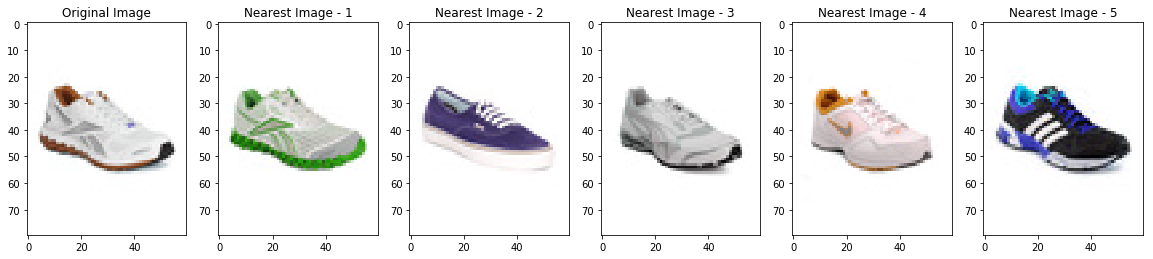

<Figure size 432x288 with 0 Axes>

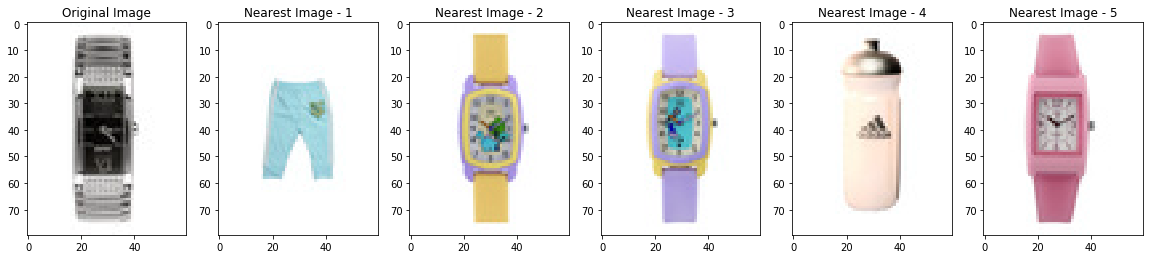

<Figure size 432x288 with 0 Axes>

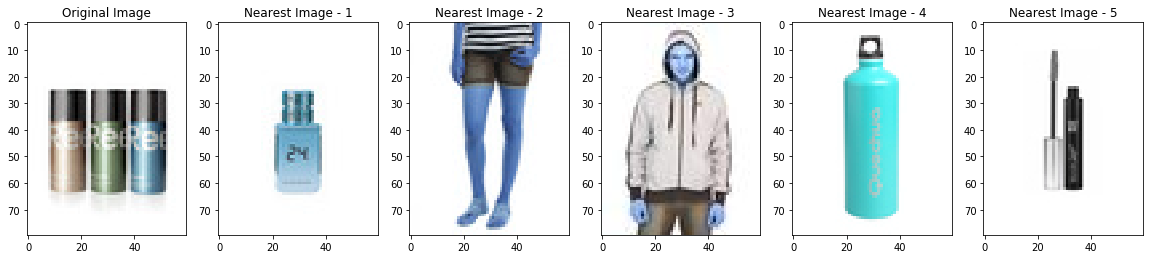

<Figure size 432x288 with 0 Axes>

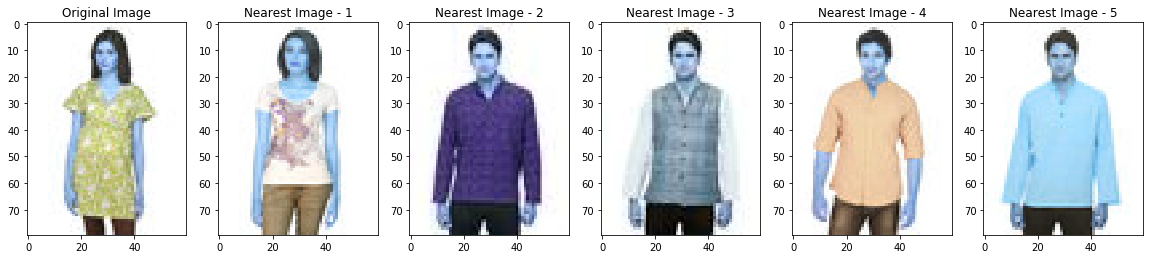

<Figure size 432x288 with 0 Axes>

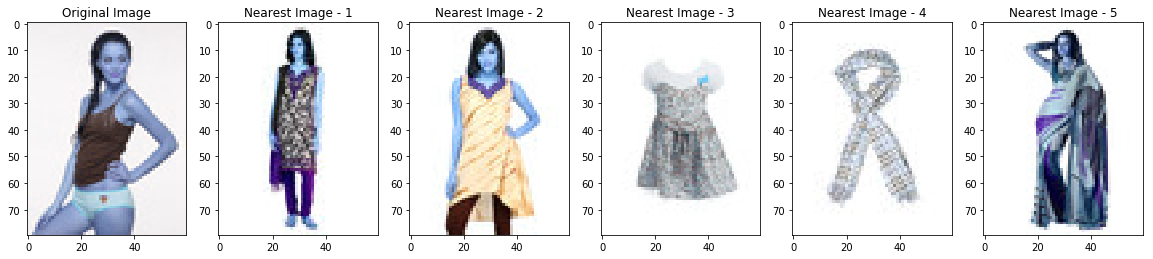

In [15]:
from skimage.measure import compare_nrmse
from sklearn.metrics.pairwise import cosine_similarity

def plot_nearest(path_img_1, list_nearest):
    """
    Plots the test image and the nearest image that was given to it
    """
    plt.figure()
    plt.figure(figsize= (20,5))
    plt.subplot(1,6,1)
    plt.imshow(cv2.imread(path_img_1))
    plt.title('Original Image')
    plt.subplot(1,6,2)
    plt.imshow(cv2.imread(list_nearest[0]))
    plt.title('Nearest Image - 1')
    plt.subplot(1,6,3)
    plt.imshow(cv2.imread(list_nearest[1]))
    plt.title('Nearest Image - 2')
    plt.subplot(1,6,4)
    plt.imshow(cv2.imread(list_nearest[2]))
    plt.title('Nearest Image - 3')
    plt.subplot(1,6,5)
    plt.imshow(cv2.imread(list_nearest[3]))
    plt.title('Nearest Image - 4')
    plt.subplot(1,6,6)
    plt.imshow(cv2.imread(list_nearest[4]))
    plt.title('Nearest Image - 5')

def find_img_cosine(path_img_1, path_img_2):
    """
    Returns the cosine similarity between two images
    """
    img1 = cv2.imread(path_img_1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = np.reshape(img1,(len(img1)*len(img1[0]),1))
    img1 = [x[0] for x in img1]
    
    img2 = cv2.imread(path_img_2)
    img2 =  cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = np.reshape(img2,(len(img2)*len(img2[0]),1))
    img2 = [x[0] for x in img2]
    
    try:
        return [cosine_similarity([img1],[img2])[0][0]]
    except:
        print ("Different Dimensions, return empty array")
        return []
    
test_descriptor_mean_cosine = []
test_image_cosine = []
for test in tqdm(test_data):
    hogs = find_hog(cv2.imread(test))
    hogs = [x[0] for x in hogs]
    distances, indexes = nbrs.kneighbors([hogs])
    test_img = cv2.imread(test)
    local_cos_sim = []
    local_image_cosine = []
    for i in range(N_Wanted):
        nearest = list(dic_hog.keys())[list(indexes)[0][i]]
        local_cos_sim.append(cosine_similarity([hogs],[dic_hog[nearest]])[0][0])
        local_image_cosine+=find_img_cosine(test,nearest)
    test_descriptor_mean_cosine.append(np.mean(local_cos_sim)) 
    test_image_cosine.append(np.mean(local_image_cosine))
    nearest = [list(dic_hog.keys())[indexes[0][x]] for x in range(N_Wanted)]
    plot_nearest(test, nearest)
    
print ("Global Mean Cosine Similarity Descriptor is :", np.mean(test_descriptor_mean_cosine))
print ("Global Mean Cosine Similarity Image for is :", np.mean(test_image_cosine))